# Invariant mass from electrons
## Dataset
The data contains information about the motion and kinetics of two electrons, result of the decay of different particles generated from protons collisions in the CMS experiment, in this case the Run 1. 

"The CMS collaboration has approved the release of 100k dielectron events in the invariant mass range 2-110 GeV for use in outreach and education."

Features:
 - Run: The run number of the event.
 - Event: The event number.
 - E: The total energy of the electron (GeV).
 - px,py,pz: The components of the momemtum of the electron (GeV).
 - pt: The transverse momentum of the electron (GeV).
 - eta: The pseudorapidity of the electron.
 - phi: The phi angle of the electron (rad).
 - Q: The charge of the electron.
 - M: The invariant mass of two electrons (GeV).

Sources: 
 - https://opendata.cern.ch/record/304
 - https://www.kaggle.com/datasets/fedesoriano/cern-electron-collision-data/data

## About this notebook
The goal of this notebook is to predict de invariant mass using tree-based models: Decision Tree (Scikit-learn), Random Forest (Scikit-learn) and Gradient Boosting Machine (XGBoost), compare the performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Regression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Track training duration
import time 

# Data analysis

## Pre-processing

In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/cern-electron-collision-data/dielectron.csv')

# First rows of the dataset
print(df.head())

# Features
print(df.columns.values)

      Run      Event        E1      px1         py1       pz1       pt1  \
0  147115  366639895  58.71410  -7.31132  10.531000 -57.29740  12.82020   
1  147115  366704169   6.61188  -4.15213  -0.579855  -5.11278   4.19242   
2  147115  367112316  25.54190 -11.48090   2.041680  22.72460  11.66100   
3  147115  366952149  65.39590   7.51214  11.887100  63.86620  14.06190   
4  147115  366523212  61.45040   2.95284 -14.622700 -59.61210  14.91790   

      eta1     phi1  Q1       E2        px2      py2      pz2       pt2  \
0 -2.20267  2.17766   1  11.2836  -1.032340 -1.88066 -11.0778   2.14537   
1 -1.02842 -3.00284  -1  17.1492 -11.713500  5.04474  11.4647  12.75360   
2  1.42048  2.96560   1  15.8203  -1.472800  2.25895 -15.5888   2.69667   
3  2.21838  1.00721   1  25.1273   4.087860  2.59641  24.6563   4.84272   
4 -2.09375 -1.37154  -1  13.8871  -0.277757 -2.42560 -13.6708   2.44145   

       eta2      phi2  Q2         M  
0 -2.344030 -2.072810  -1   8.94841  
1  0.808077  2.734920 

In [3]:
# 'px1' has an extra space 'px1 '. Let's fix it to prevent any issue:
df = df.rename(columns = {'px1 ':'px1'})

Let's look for duplicates and missing M values. 

In [4]:
print('Rows of data:', len(df))
print('Duplicates:', df.duplicated().sum())
print('Missing M values:', df['M'].isnull().sum())

Rows of data: 100000
Duplicates: 23
Missing M values: 85


Duplicates and missing value rows are only 0.1% of the data. Given that this also can mean malfunctioning of the detector for that data is better to drop it. 

In [5]:
df = df.drop_duplicates()
df = df.dropna(subset=['M'])
print('Rows of data:', len(df))

Rows of data: 99892


### Reordering data
When a particle decays, the label of the electron doesn't matter, but only the joint data of both electrons. This way, given that tree-based models are going to be implemented, one can re-arrange the data such that the electrons with greater transverse momentum are gonna be considered as electron 1. This might help to improve the model when is making the partition of the state space, since doesn't need to learn that the case $p_{T1} > p_{T2}$ is equivalent in importance to $p_{T1} < p_{T2}$.

**Note**: After training the input data that is going to be asked to the model should be ordered in this same way.

In [6]:
mask_swap = df['pt1'] < df['pt2']

# All the values related with the label must be changed so the dataframe doesn't mix properties
pairs_to_swap = [
    ('E1', 'E2'),
    ('px1', 'px2'),
    ('py1', 'py2'),
    ('pz1', 'pz2'),
    ('pt1', 'pt2'),
    ('eta1', 'eta2'),
    ('phi1', 'phi2'),
    ('Q1', 'Q2')
]

for col1, col2 in pairs_to_swap:
    # Access the rows matching the mask and swap the values
    df.loc[mask_swap, [col1, col2]] = df.loc[mask_swap, [col2, col1]].values

# Verification
reorder_count = (df['pt1'] >= df['pt2']).sum()
print('Events where pt1 >= pt2: ', reorder_count)
print('Total events: ', len(df))


Events where pt1 >= pt2:  99892
Total events:  99892


### Physical and technical consistency
It's also important to consider the physical consistency of the data. This is, energy, transverse momentum and mass values should be positive to have physical meaning, if not then the row is likely to be corrupted. 

In [7]:
energy_neg = (df['E1']<0).sum() + (df['E2']<0).sum()
print('Negative energy: ', energy_neg)

mass_neg = (df['M']<0).sum()
print('Negative mass: ', mass_neg)

p_neg = (df['pt1']<0).sum() + (df['pt2']<0).sum()
print('Negative transverse momentum: ', p_neg)

Negative energy:  0
Negative mass:  0
Negative transverse momentum:  0


On the other hand, given the capacity of the detector, values $|\eta|\leq 3$ can be consider as not reliable. 

https://arxiv.org/abs/2012.07035

In [8]:
eta_outliers1 = (df['eta1'] <= -3) | (df['eta1'] >= 3) 
eta_outliers2 = (df['eta2'] <= -3) | (df['eta2'] >= 3)
print('eta outliers:', eta_outliers1.sum() + eta_outliers2.sum())

eta outliers: 4


In [9]:
# Drop eta outliers
eta_valid = (df['eta1'] >= -3) & (df['eta1'] <= 3) \
           & (df['eta2'] >= -3) & (df['eta2'] <= 3)

df = df[eta_valid]  # keeps only rows that accomplish the condition
print('Total rows: ', len(df))


Total rows:  99888


Another quantity to review is $\phi$, this is a value in radians such that $-\pi \leq \phi \geq \pi$. Any other value out of this interval would be anormal. 

In [10]:
phi_outliers1 = (df['phi1'] <= -np.pi) | (df['phi1'] >= np.pi) 
phi_outliers2 = (df['phi2'] <= -np.pi) | (df['phi2'] >= np.pi)
print('phi outliers:', phi_outliers1.sum() + phi_outliers2.sum())

phi outliers: 0


For the remaining quantities we can check on the outliers, but they should be considered in the training, as a standard in high energy physics, since no common events are likely to happen and have physical importance. However, a quick check on no possible physical values that exceed the collision energy is done. In this case for the Run 1, the energy invested in the collisions was 4 TeV.

[https://home.web.cern.ch/news/press-release/cern/first-lhc-protons-run-ends-new-milestone#:~:text=The%20luminosity%2C%20a%20crucial%20parameter,to%208%20TeV%20in%202012.](http://)

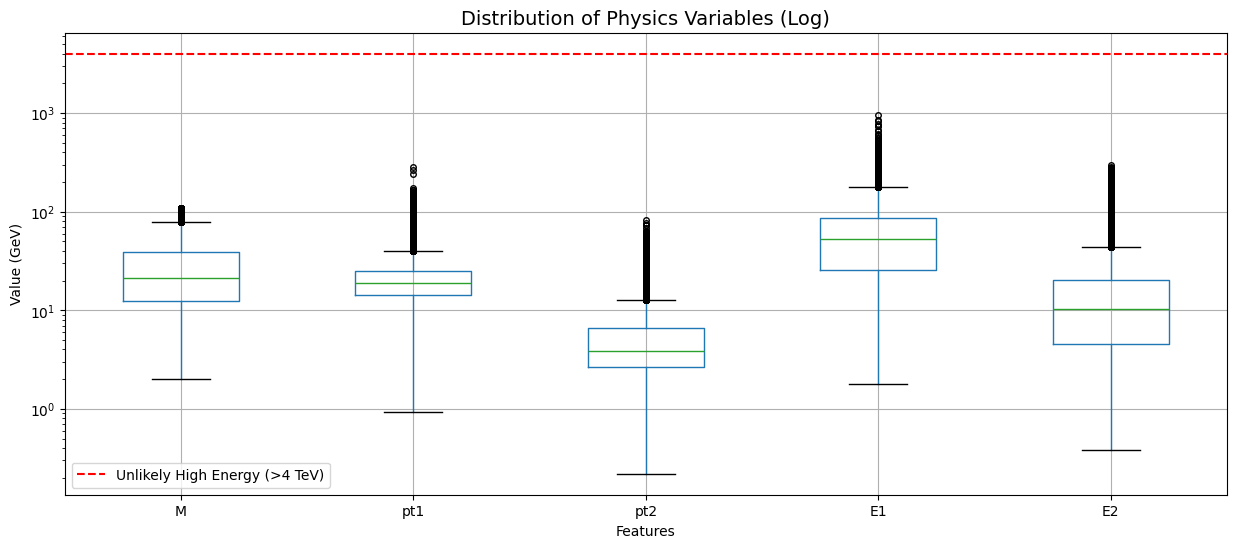

In [11]:
cols_to_check = ['M', 'pt1', 'pt2','E1', 'E2']

plt.figure(figsize=(15, 6))
# Boxplot
df.boxplot(column=cols_to_check, grid=True, flierprops=dict(marker='.', markersize=8, linestyle='none'))
plt.yscale('log')
plt.title('Distribution of Physics Variables (Log)', fontsize=14)
plt.ylabel('Value (GeV)')
plt.xlabel('Features')

# Above experiment's energy
plt.axhline(y=4000, color='red', linestyle='--', label='Unlikely High Energy (>4 TeV)')
plt.legend()
plt.show()

For the longitudinal momentum also we can look for values bigger than 4 TeV. But in this case as it is a directional quantitiy can be negative.

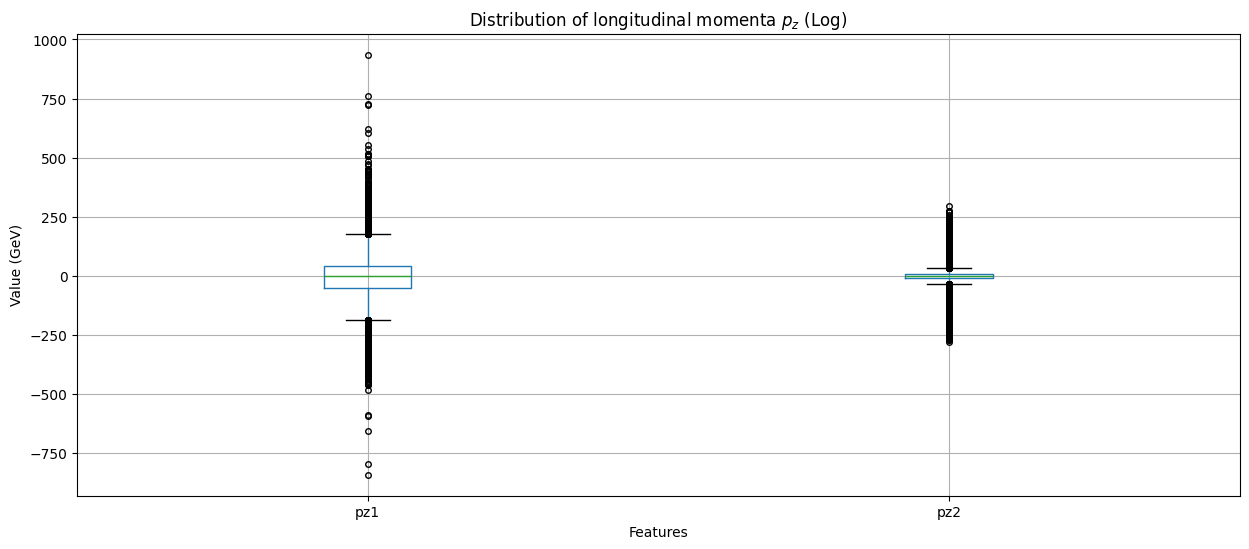

In [12]:
plt.figure(figsize=(15, 6))
# Boxplot
df.boxplot(column=['pz1','pz2'], grid=True, flierprops=dict(marker='.', markersize=8, linestyle='none'))
plt.title(r'Distribution of longitudinal momenta $p_z$ (Log)')
plt.ylabel('Value (GeV)')
plt.xlabel('Features')
plt.show()

## Pre-visualization
The objective is learn the invariant mass through regression, so let's take a quick look to it. Note that 3 particles can be found by comparing theoretical values with the peaks in the data.

https://pdg.lbl.gov/2025/listings/contents_listings.html

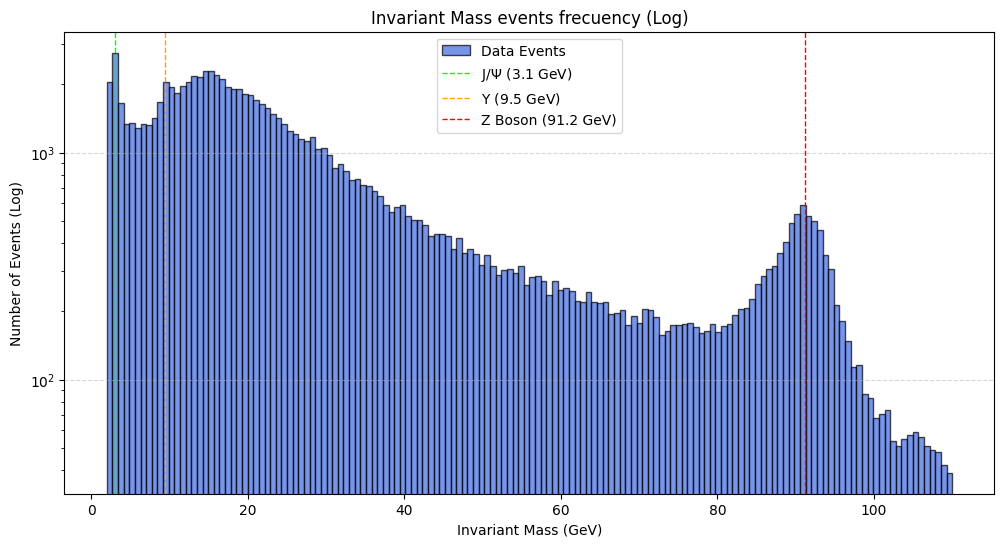

In [13]:
plt.figure(figsize=(12,6))

# Histogram
plt.hist(df['M'], bins=150, log=True, color='royalblue', edgecolor='black', alpha=0.7, label='Data Events')

# J/Psi
plt.axvline(x=3.09, color='lime', linestyle='--', linewidth=1, label=r'J/$\Psi$ (3.1 GeV)')
# Upsilon
plt.axvline(x=9.46, color='orange', linestyle='--', linewidth=1, label=r'$\Upsilon$ (9.5 GeV)')
# Z-Boson 
plt.axvline(x=91.2, color='red', linestyle='--', linewidth=1, label='Z Boson (91.2 GeV)')

plt.title('Invariant Mass events frecuency (Log)')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events (Log)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Training the model

## Split of data
For this case, there are two coordinate systems taken into account in the features, cartesian and detector (spherical modified) coordinates. The description of the system can be done uniquely with one of this, such that it is possible to train the model for each kind of coordinates and contemplate a general model where both are considered, hence knowing which is prefered by the model to represent the system. 

Three dataframes are created to this end.
- General
- Cartesian coordinates
- Detector coordinates

The split of data in this work is done to perform Nested Cross-Validation.

In [14]:
# This is how the data will be split for the Nested Cross-Validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=24)
inner_cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=24)

# Since we want to separate into different coordinate systems
def Split(df,feature_cols):
    X = df[feature_cols]
    y = df['M']
    return X, y

## Training
To tune the hyperparameters RandomizedSearchCV is used for the Decision Tree, Random Forest and XGBoost. This will do all the corresponding training times shorter than using standard GridSearchCV. Later, the final train is performed based on the best found hyperparameters. 

In [15]:
def DecisionTreeTune(X, y, outer_cv, inner_cv):
    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_leaf': [1, 5, 25], # Min elements per partition after split
        'min_samples_split': [2, 20, 40] # Min elements in node before split
    }

    decision_tree = RandomizedSearchCV(
        DecisionTreeRegressor(random_state=24),
        param_distributions=param_grid,
        n_iter=5,
        cv=inner_cv, # Train on 80%, Validate on 20% 
        # scoring='neg_mean_squared_error',
        return_train_score = True,
        n_jobs=-1,
        random_state=24
    )

    start_time = time.time() # Start tracking duration of training

    tree_scores = cross_validate(decision_tree, X, y, cv=outer_cv, return_train_score=True, return_estimator=True)
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"Nested Cross Validation in {duration:.2f} seconds ({duration/60:.2f} minutes).")

    return tree_scores

In [16]:
def RandomForestTune(X, y, outer_cv, inner_cv):
    rf_params = {
        # 'n_estimators': [50, 100], # Trees
        'max_depth': [5, 10, 20, None],        
        'min_samples_leaf': [1, 5, 20],       
        'max_features': ['sqrt', 0.5, 1.0] # How many features to check per split
    }
    
    rf = RandomizedSearchCV(
        RandomForestRegressor(n_estimators = 100, random_state=24),
        param_distributions=rf_params,
        n_iter=5, # Random combinations
        cv=inner_cv, # Train on 80%, Validate on 20% 
        # scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=24,
    )

    start_time = time.time() # Start tracking duration of training
    
    rf_scores = cross_validate(rf, X, y, cv=outer_cv, return_train_score=True, return_estimator=True)
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"Nested Cross Validation in {duration:.2f} seconds ({duration/60:.2f} minutes).")
    
    return rf_scores

In [17]:
def XgbTune(X, y, outer_cv, inner_cv):
    n_features = X.shape[1]
    sqrt_ratio = np.sqrt(n_features) / n_features
    
    xgb_params = {
        # 'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.05, 0.1, 0.3], 
        'max_depth': [5, 10, 20],               
        'subsample': [0.7, 0.8, 1.0], # % of data per tree
        'colsample_bytree': [sqrt_ratio, 0.5, 1.0], # % of features per tree
        'min_child_weight': [1, 5, 25]
    }

    xgb = RandomizedSearchCV(
        XGBRegressor(n_estimators = 100, random_state=24, n_jobs=1),
        param_distributions=xgb_params,
        n_iter=5, # Random combinations (I'll try 10)
        cv=inner_cv, # Train on 80%, Validate on 20% 
        # scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=24,
    )

    start_time = time.time() # Start tracking duration of training
    
    xgb_scores = cross_validate(xgb, X, y, cv=outer_cv, return_train_score=True, return_estimator=True)

    end_time = time.time()
    duration = end_time - start_time
    print(f"Nested Cross Validation in {duration:.2f} seconds ({duration/60:.2f} minutes).")

    return xgb_scores

## Training General

In [18]:
# Drop Run and Event because they don't have physical relevance for the training
feature_cols_gen = df.drop(columns=['Run', 'Event', 'M']).columns.tolist()
X_gen, y_gen = Split(df,feature_cols_gen)

In [19]:
tree_gen_scores = DecisionTreeTune(X_gen, y_gen, outer_cv, inner_cv)

# To store results
results = {}

results['General']={}
results['General']['tree'] = tree_gen_scores

Nested Cross Validation in 80.96 seconds (1.35 minutes).


In [20]:
rf_gen_scores = RandomForestTune(X_gen, y_gen, outer_cv, inner_cv)
results['General']['rf'] = rf_gen_scores

Nested Cross Validation in 2880.66 seconds (48.01 minutes).


In [21]:
xgb_gen_scores = XgbTune(X_gen, y_gen, outer_cv, inner_cv)
results['General']['xgb'] = xgb_gen_scores

Nested Cross Validation in 829.49 seconds (13.82 minutes).


## Training Cartesian coordinates

In [22]:
feature_cols_car = ['E1', 'px1', 'py1', 'pz1', 'Q1', 'E2', 'px2', 'py2', 'pz2', 'Q2']
X_car, y_car = Split(df,feature_cols_car)

In [23]:
tree_car_scores = DecisionTreeTune(X_car, y_car, outer_cv, inner_cv)
results['Cartesian']={}
results['Cartesian']['tree'] = tree_car_scores

Nested Cross Validation in 47.15 seconds (0.79 minutes).


In [24]:
rf_car_scores = RandomForestTune(X_car, y_car, outer_cv, inner_cv)
results['Cartesian']['rf']= rf_car_scores

Nested Cross Validation in 1788.93 seconds (29.82 minutes).


In [25]:
xgb_car_scores = XgbTune(X_car, y_car, outer_cv, inner_cv)
results['Cartesian']['xgb'] = xgb_car_scores

Nested Cross Validation in 481.51 seconds (8.03 minutes).


## Training Detector coordinates

In [26]:
feature_cols_det = ['E1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'pt2', 'eta2', 'phi2', 'Q2']
X_det, y_det = Split(df,feature_cols_det)

In [27]:
tree_det_scores = DecisionTreeTune(X_det, y_det, outer_cv, inner_cv)
results['Detector']={}
results['Detector']['tree'] = tree_det_scores

Nested Cross Validation in 46.39 seconds (0.77 minutes).


In [28]:
rf_det_scores = RandomForestTune(X_det, y_det, outer_cv, inner_cv)
results['Detector']['rf'] = rf_det_scores

Nested Cross Validation in 1717.40 seconds (28.62 minutes).


In [29]:
xgb_det_scores = XgbTune(X_det, y_det, outer_cv, inner_cv)
results['Detector']['xgb'] = xgb_det_scores

Nested Cross Validation in 563.43 seconds (9.39 minutes).


# Evaluation

In [30]:
# Dataframe to store the results

results_list = []
for coordinate, models in results.items():
    for model, scores in models.items():
        for fold in range(len(scores['test_score'])):
            results_list.append({
                'fold': fold,
                'coordinate': coordinate,
                'model': model, 
                'test_score':scores['test_score'][fold],
                'train_score':scores['train_score'][fold],
                'fit_time': scores['estimator'][fold].refit_time_
            })

df_results = pd.DataFrame(results_list)

df_results

,fold,coordinate,model,test_score,train_score,fit_time
0,0,General,tree,0.888543,0.964002,3.666833
1,1,General,tree,0.879779,0.950135,3.618952
2,2,General,tree,0.884920,0.954628,3.605962
3,3,General,tree,0.892537,0.956503,3.598291
4,4,General,tree,0.890545,0.956654,3.508491
...,...,...,...,...,...,...
85,5,Detector,xgb,0.983020,0.997753,9.361830
86,6,Detector,xgb,0.982241,0.997549,9.162962
87,7,Detector,xgb,0.981960,0.997490,9.236368
88,8,Detector,xgb,0.981348,0.997630,9.409316


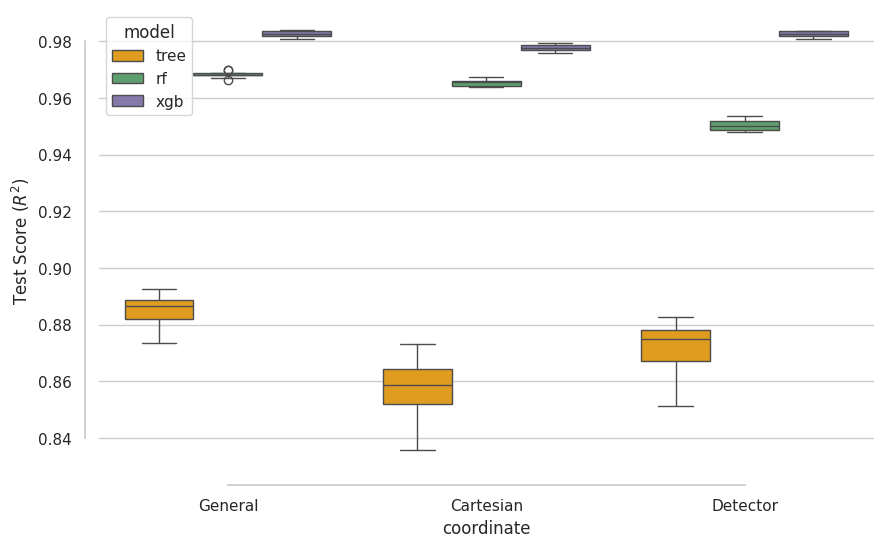

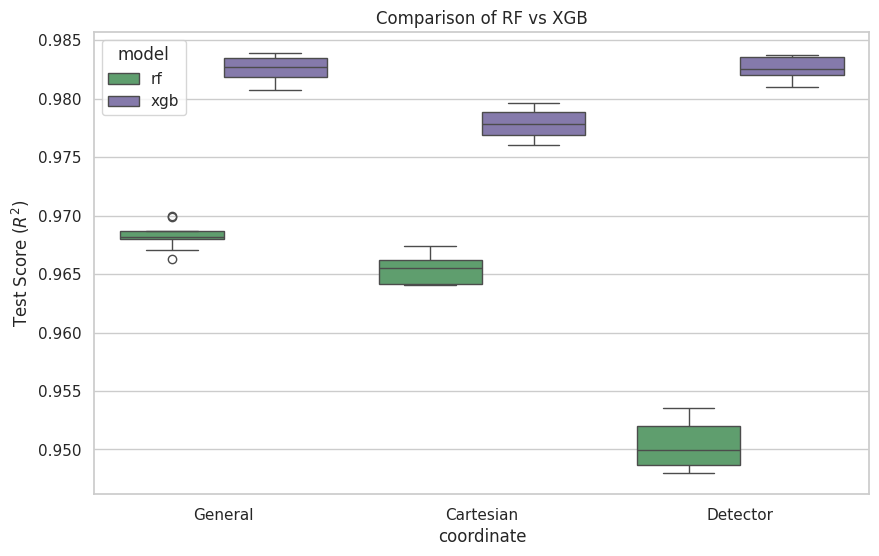

In [31]:
plt.figure(figsize=(10, 6))
sns.set_theme(style='whitegrid')
sns.boxplot(x='coordinate', y='test_score',
            hue='model', palette=['orange', 'g', 'm'],
            data=df_results)

sns.despine(offset=10, trim=True)
plt.ylabel('Test Score ($R^2$)')
plt.show()

# Zoom in the best performers
df_best = df_results[df_results['model'] != 'tree']

plt.figure(figsize=(10, 6))
sns.set_theme(style='whitegrid') 
sns.boxplot(x='coordinate', y='test_score',
            hue="model", palette=['g', 'm'], # Green (RF) and Blue (XGB)
            data=df_best)

plt.title('Comparison of RF vs XGB')
plt.ylabel('Test Score ($R^2$)')
plt.show()

We can conclude based on the score that the best model to train this kind of data is XGBoost for the general system (both coordinate systems). Although it is important to mention the low standard deviation of the random forest in the general system, which still has a good performance. Once we identify this, we can use the estimators that we have to predict data and check the performance of this specific model. Let's take XGBoost for the general system.

In [32]:
estimators = results['General']['xgb']['estimator']

# Store the predictions
y_pred = np.zeros(len(y_gen))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_gen, y_gen)):
    model = estimators[fold]
    
    # Test data for this fold
    X_test_fold = X_gen.iloc[test_idx]
    
    # Predict
    mass_prediction = model.predict(X_test_fold)
    
    # Place predictions into the correct slots in the main array
    y_pred[test_idx] = mass_prediction

{'rmse': np.float64(3.3265921185692373), 'mae': 2.0018442894871824, 'r2': 0.9826512324875067}


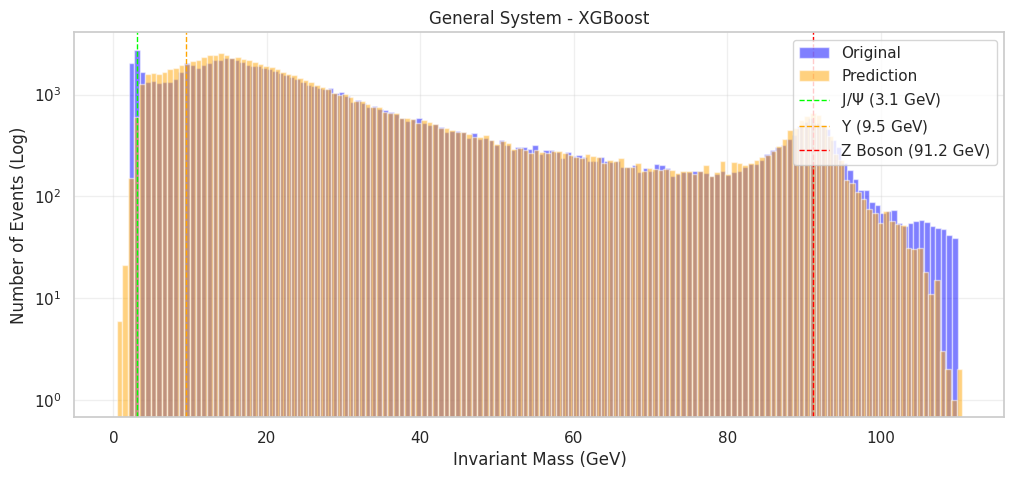

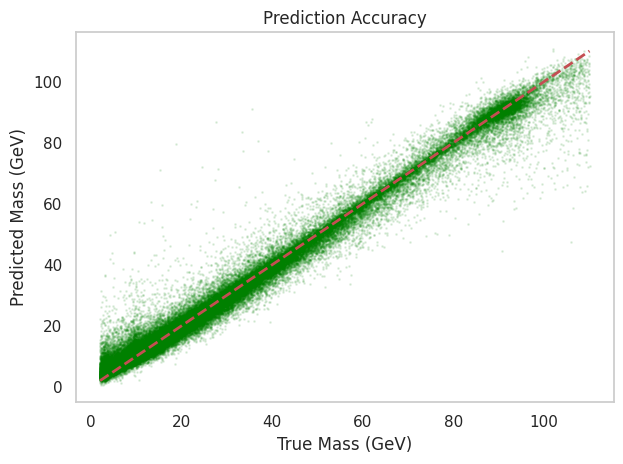

In [33]:
metrics = {
        'rmse': np.sqrt(mean_squared_error(y_gen, y_pred)),
        'mae': mean_absolute_error(y_gen, y_pred),
        'r2': r2_score(y_gen, y_pred)
    }

print(metrics)
    
# Mass distribution histogram
plt.figure(figsize=(12, 5))
plt.hist(y_gen, log = True, bins=150, alpha=0.5, label='Original', color='blue')
plt.hist(y_pred, log = True, bins=150, alpha=0.5, label='Prediction', color='orange')
# J/Psi
plt.axvline(x=3.09, color='lime', linestyle='--', linewidth=1, label=r'J/$\Psi$ (3.1 GeV)')
# Upsilon
plt.axvline(x=9.46, color='orange', linestyle='--', linewidth=1, label=r'$\Upsilon$ (9.5 GeV)')
# Z-Boson 
plt.axvline(x=91.2, color='red', linestyle='--', linewidth=1, label='Z Boson (91.2 GeV)')

plt.xlabel("Invariant Mass (GeV)")
plt.ylabel("Number of Events (Log)")
plt.title('General System - XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Prediction vs Truth
plt.figure()
plt.scatter(y_gen, y_pred, alpha=0.1, s=1, color='green')
plt.plot([y_gen.min(), y_gen.max()], [y_gen.min(), y_gen.max()], 'r--', lw=2)
plt.xlabel("True Mass (GeV)")
plt.ylabel("Predicted Mass (GeV)")
plt.title("Prediction Accuracy")
plt.grid()
plt.tight_layout()
plt.show()


Notice the maximum and minimum of this distribution is not well predicted, comparing with the original data. It can be an issue because we lost the peak of J/$\Psi$ particle. We can see from it what were the most important features. In this case as we did many folds, we take an average of them.

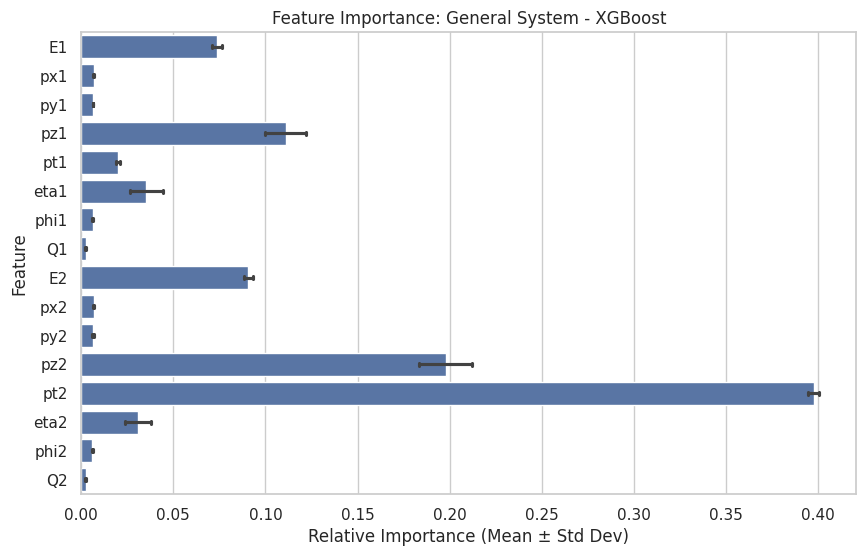

In [34]:
# Store feature imporatance
importances_list = []
for fold_idx, search_cv in enumerate(estimators):
    best_model = search_cv.best_estimator_
    
    # Store in a temporary dataframe
    temp_df = pd.DataFrame({
        'Feature': best_model.feature_names_in_,
        'Importance': best_model.feature_importances_,
        'Fold': fold_idx
    })
    importances_list.append(temp_df)

# Combine all folds
df_imp = pd.concat(importances_list)

# Plot
plt.figure(figsize=(10, 6))
sns.set_theme(style='whitegrid')

# Bar plot with error bars
sns.barplot(data=df_imp, x='Importance', y='Feature', errorbar='sd', capsize=0.1)

plt.title('Feature Importance: General System - XGBoost')
plt.xlabel('Relative Importance (Mean ± Std Dev)')
plt.show()

Probably $p_{t1}$ is not as important as $p_{t2}$ because of the reordering that we did in the beginnig.

Let's see the Random Forest in the General System which has small standard deviation.

In [35]:
estimators_rf = results['General']['rf']['estimator']

# Store the predictions
y_pred_rf = np.zeros(len(y_gen))

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_gen, y_gen)):
    model_rf = estimators_rf[fold]
    
    # Test data for this fold
    X_test_fold = X_gen.iloc[test_idx]

    # Place predictions into the correct slots in the main array
    y_pred_rf[test_idx] = model_rf.predict(X_test_fold)

{'rmse': np.float64(4.496330671074243), 'mae': 3.019994380230423, 'r2': 0.9683053467881825}


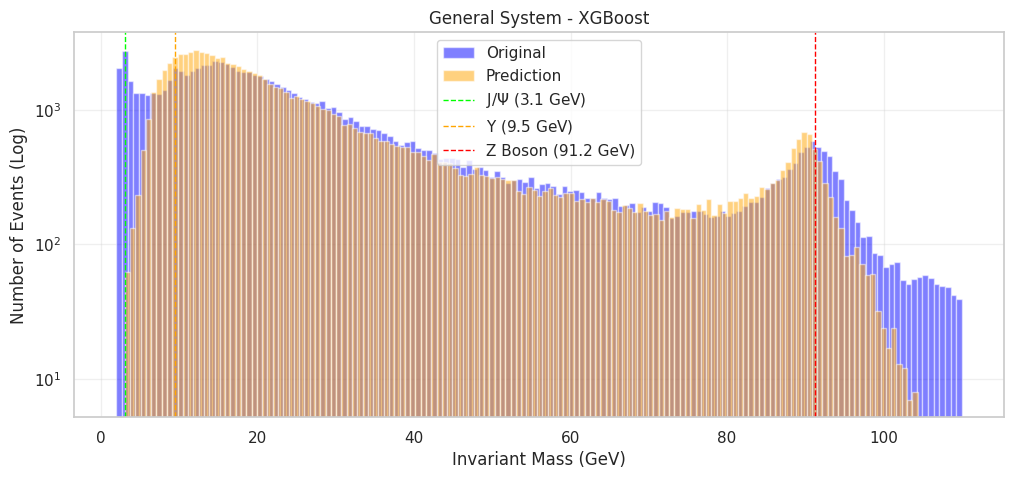

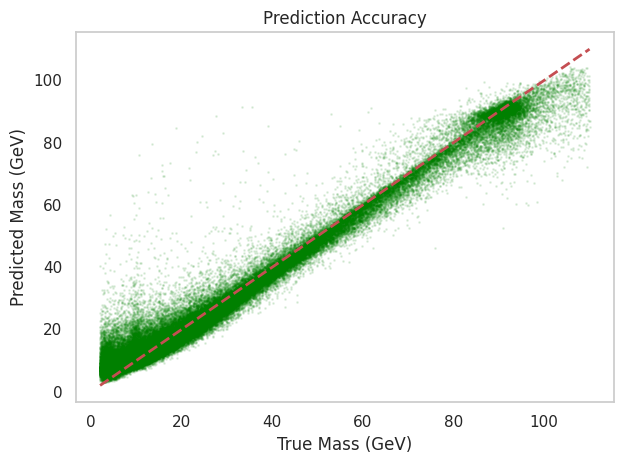

In [36]:
metrics_rf = {
        'rmse': np.sqrt(mean_squared_error(y_gen, y_pred_rf)),
        'mae': mean_absolute_error(y_gen, y_pred_rf),
        'r2': r2_score(y_gen, y_pred_rf)
    }

print(metrics_rf)

# Mass distribution histogram
plt.figure(figsize=(12, 5))
plt.hist(y_gen, log = True, bins=150, alpha=0.5, label='Original', color='blue')
plt.hist(y_pred_rf, log = True, bins=150, alpha=0.5, label='Prediction', color='orange')
# J/Psi
plt.axvline(x=3.09, color='lime', linestyle='--', linewidth=1, label=r'J/$\Psi$ (3.1 GeV)')
# Upsilon
plt.axvline(x=9.46, color='orange', linestyle='--', linewidth=1, label=r'$\Upsilon$ (9.5 GeV)')
# Z-Boson 
plt.axvline(x=91.2, color='red', linestyle='--', linewidth=1, label='Z Boson (91.2 GeV)')

plt.xlabel("Invariant Mass (GeV)")
plt.ylabel("Number of Events (Log)")
plt.title('General System - XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Prediction vs Truth
plt.figure()
plt.scatter(y_gen, y_pred_rf, alpha=0.1, s=1, color='green')
plt.plot([y_gen.min(), y_gen.max()], [y_gen.min(), y_gen.max()], 'r--', lw=2)
plt.xlabel("True Mass (GeV)")
plt.ylabel("Predicted Mass (GeV)")
plt.title("Prediction Accuracy")
plt.grid()
plt.tight_layout()
plt.show()

# Prospects
1. Classification model to identify particles detected in the Run.
2. Compare if reordering data, as it was done here, represents a good advantage or the lost of generalization is not worth it.
3. Explore the application of a symbolic regression model (PySR)
4. Modify the scoring, convert the data or sample more low value data such that the model learns to predict $J/\Psi$ peak.